The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar. (dataset reference: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?datasetId=1866141&sortBy=voteCount)

Notice a much stronger correlation with redshift when compared to the other two types of objects! Might be due to more data points from further galaxies which contribute to the detection of this correlation (stars can't be detected as far as galaxies nor quasars).

Potentially using data from i and r (g and z) find the redshift? Given a galaxy?

Use redshift as y-value to be fitted! -> new jupyter notebook (SDSS - 5) Galaxies regression of the redshift using r and i filters.

example here: https://iopscience.iop.org/article/10.1088/0004-637X/692/1/L5/meta

here in the case of cosmology: https://iopscience.iop.org/article/10.1088/0004-637X/813/1/53/meta

reference article for method: https://academic.oup.com/mnras/article/505/4/4847/6288434?login=true



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
import random
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

In [48]:
def get_train_test():
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers
    # select the row with u or z or g below 0 (should not be allowed)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)
                | (df["redshift"] <= 0)]

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    
    # WE ONLY DEAL WITH GALAXIES HERE (see SDSS - 4 for correlations)
    df = df[df["class"] == "GALAXY"]
    
    # we drop the data we are not interested in and which won't be useful
    # expect isotropic universe -> could also drop position in sky
    df = df.drop(
        columns=["alpha", "delta", "obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID", "class"], axis=1)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(axis=0)
        
    return df

# only keeps filters and redshift
df = get_train_test()
# https://datatofish.com/check-nan-pandas-dataframe/
# https://datatofish.com/rows-with-nan-pandas-dataframe/
print(df.isnull().values.any())

False


1.995524

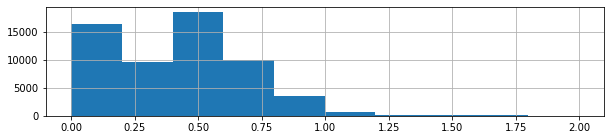

In [55]:
df["redshift"].hist(figsize=(10, 2));

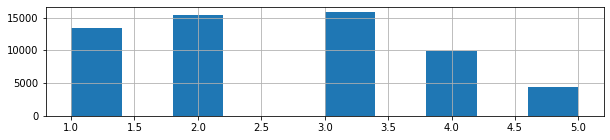

In [85]:
df["redshift_cat"] = pd.cut(df["redshift"],
                            bins=[0., 0.15, 0.45, 0.6, 0.8, np.inf],
                            labels=[1, 2, 3, 4, 5])
df["redshift_cat"].hist(figsize=(10, 2));

In [87]:
# stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
for train_index, test_index in split.split(df, df["redshift_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

strat_train_set
# will indicate the proportion of districts in each category
#print(df["redshift_cat"].value_counts() / len(df))
#strat_test_set["redshift_cat"].value_counts() / len(strat_test_set)

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,u,g,r,i,z,redshift,redshift_cat
11559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11944,26.34951,21.85805,20.30235,19.31511,18.93399,0.514940,3
52976,23.28175,22.56847,20.88845,19.94134,19.25902,0.525947,3
39804,18.97529,16.87559,15.86866,15.38448,15.01671,0.075421,1
29786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
41327,22.41580,20.18909,18.34374,17.75374,17.36593,0.348030,2
30675,27.19509,21.73223,20.45686,19.61238,19.26756,0.512165,3
23919,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41046,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train = train.reset_index(drop=True)

# seperate measurements (x) with class(y)
x_train = train.drop(columns=["class"], axis=1)
y_train = train["class"]

# replace all infinite values with NaN
x_train = x_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.replace([np.inf, -np.inf], np.nan)

# drop all the rows with NaN
x_train = x_train.dropna(axis=0)
y_train = y_train.dropna(axis=0)